In [27]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import json
import itertools

from extrinsic2pyramid.util.camera_pose_visualizer import CameraPoseVisualizer

## Utilities 

In [2]:
def gen_permutation_matricies():
    perms = list(itertools.permutations([0,1,2]))

    perm_mats = []

    # I would love to do this in-place, but numpy does not support in-place permutation
    for perm in perms:
        I = np.eye(3)
        I[:, :] = I[perm, :]
        perm_mats.append(I)    

    return perm_mats

perms = gen_permutation_matricies()
H, W = 800, 800

### Computing rays from the pose 

In [ ]:
def pose_to_rays(rotation, translation, focal, h, w, t_n, t_f, num_samples):
    xs = torch.arange(w)
    ys = torch.arange(h)

    h_mesh, w_mesh = torch.meshgrid(xs, ys, indexing='ij')

    pixels_unflatten = torch.stack([(w_mesh - w * .5) / focal, -(
        h_mesh - h * .5) / focal, -torch.ones_like(h_mesh)], dim=-1)
    pixels = torch.reshape(pixels_unflatten, (h*w, 3))

    dirs = torch.matmul(rotation, pixels.T).T
    dirs_tformed = torch.reshape(dirs, (h, w, 3))

    origin = torch.broadcast_to(translation, dirs_tformed.shape)

    ts = torch.linspace(t_n, t_f, steps=num_samples)

    ray_points = origin[..., None, :] + \
        dirs_tformed[..., None, :] * ts[:, None]

    return ray_points

# Exploration

## Visualize chair

### Load data

In [17]:
chair_dataset_path = "../NeRF-Scenes/chair/transforms_train.json"

with open(chair_dataset_path, 'r') as f:

    config = json.load(f)
    frames = config["frames"]
    focal = .5 * W / np.tan(.5 * float(config['camera_angle_x']))

print(focal)

1111.1110311937682


initialize camera pose visualizer


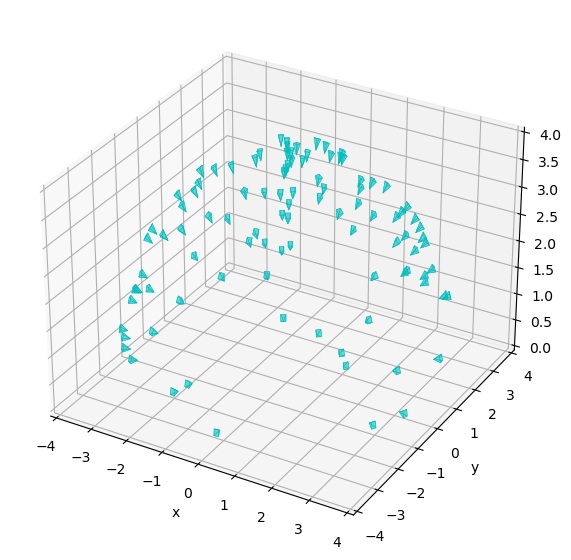

In [4]:
visualizer = CameraPoseVisualizer([-4, 4], [-4, 4], [0, 4])

for pose in frames:
    mat = np.asarray(pose["transform_matrix"], dtype=np.float32)
    R,t = mat[:3, :3], mat[:3, 3:]

    perm_R, perm_t = R, t

    mat = np.concatenate([perm_R, perm_t], axis = 1)
    mat_homog = np.concatenate([mat, np.array([[0, 0, 0, -1]])])

    
    visualizer.extrinsic2pyramid(mat_homog, 'c', 0.20)

### Okay, so the poses seem to be flipped for some reason....

Let's go a step further and compute the focal length + image resolution. Then we can plot some rays and check if they go in the right direction. 


### Plotting some points along the ray 

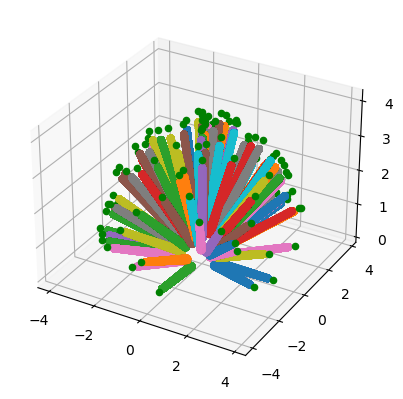

In [16]:
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

for pose in frames:
    mat = torch.from_numpy(np.asarray(pose["transform_matrix"], dtype=np.float32))

    R,t = mat[:3, :3], torch.squeeze(mat[:3, 3:])

    rays = pose_to_rays(R, t, focal, 20, 20, 0.3, 3, 50)

    x, y, z = rays[..., 0], rays[..., 1], rays[..., 2]

    x, y, z = np.reshape(x, -1), np.reshape(y, -1), np.reshape(z, -1)

    ax.scatter(x,y,z)
    x_o, y_o, z_o = list(t)
    ax.scatter(x_o, y_o, z_o, color='green')

plt.show()

#### Okay, this looks much better. I think extrinsic2pyramid plots it in a different coordinate system.... Maybe where z faces outwards from the camera? 

# Modular code

### Okay, lets now make that into a function, and test it on all the datasets

In [20]:
def plot_dataset(path):
    with open(path, 'r') as f:

        config = json.load(f)
        frames = config["frames"]
        focal = .5 * W / np.tan(.5 * float(config['camera_angle_x']))

    fig = plt.figure()

    ax = fig.add_subplot(111, projection='3d')

    for pose in frames:
        mat = torch.from_numpy(np.asarray(pose["transform_matrix"], dtype=np.float32))

        R,t = mat[:3, :3], torch.squeeze(mat[:3, 3:])

        rays = pose_to_rays(R, t, focal, 20, 20, 0.3, 3, 50)

        x, y, z = rays[..., 0], rays[..., 1], rays[..., 2]

        x, y, z = np.reshape(x, -1), np.reshape(y, -1), np.reshape(z, -1)

        ax.scatter(x,y,z)
        x_o, y_o, z_o = list(t)
        ax.scatter(x_o, y_o, z_o, color='green')

    plt.show()

## Plotting Drums

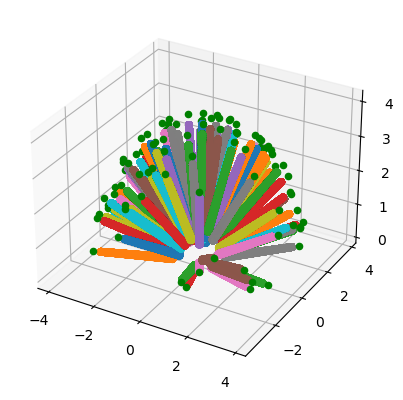

In [21]:
drums_dataset_path = "../NeRF-Scenes/drums/transforms_train.json"

plot_dataset(drums_dataset_path)

## Plotting Ficus

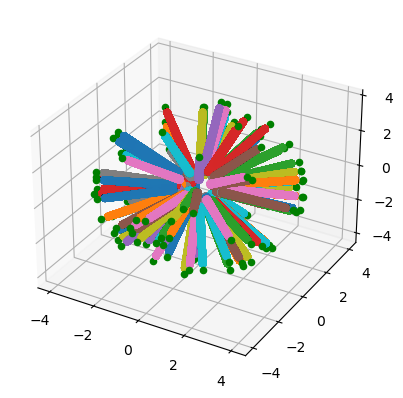

In [22]:
ficus_dataset_path = "../NeRF-Scenes/ficus/transforms_train.json"

plot_dataset(ficus_dataset_path)

## Plotting hotdog

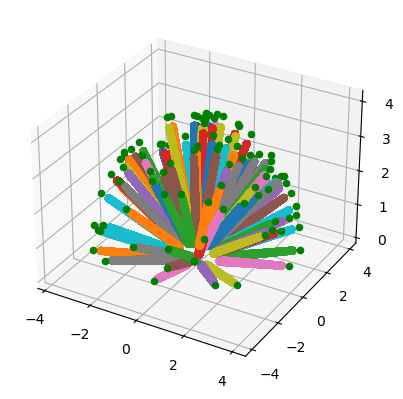

In [23]:
hotdog_dataset_path = "../NeRF-Scenes/hotdog/transforms_train.json"

plot_dataset(hotdog_dataset_path)

## Plotting lego

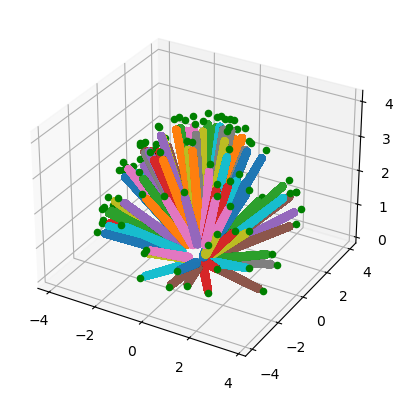

In [24]:
lego_dataset_path = "../NeRF-Scenes/lego/transforms_train.json"

plot_dataset(lego_dataset_path)

## Plotting materials

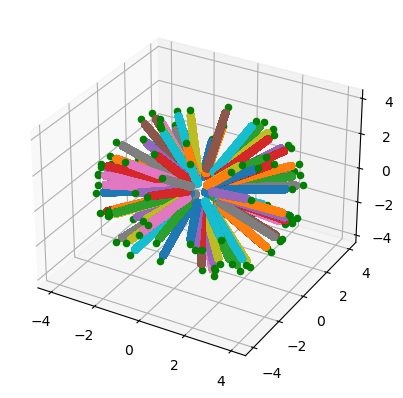

In [25]:
materials_dataset_path = "../NeRF-Scenes/materials/transforms_train.json"

plot_dataset(materials_dataset_path)

## Plotting ship

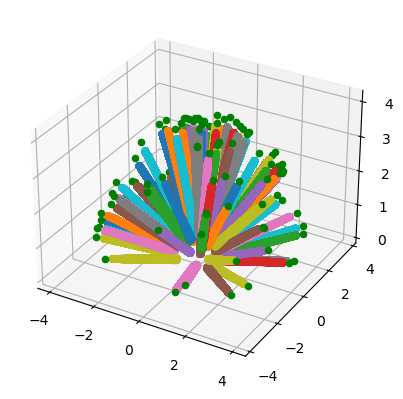

In [26]:
ship_dataset_path = "../NeRF-Scenes/ship/transforms_train.json"

plot_dataset(ship_dataset_path)